# Deep Learning
## HW3 - Problem 1


1.   Full Name: Amir Mohammad Yaghoobian zadeh
2.   Student Number: 401300525



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
import cv2
import tqdm
from torchvision.io import read_image
import torchvision
from torch.utils.tensorboard import SummaryWriter

e:\project\ann\new\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


# part A

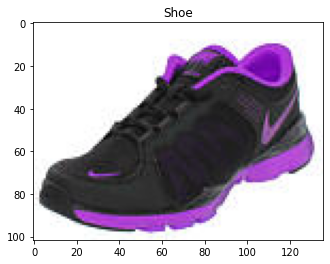

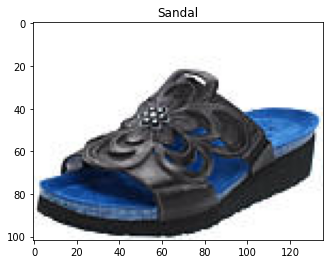

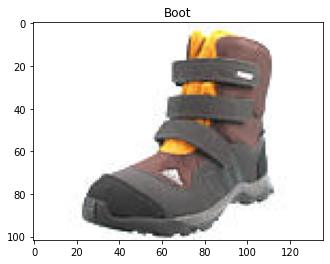

#train: 10499, #test: 4499


In [3]:

folder_shoe = 'archive/Shoe vs Sandal vs Boot Dataset/Shoe'
folder_sandal = 'archive/Shoe vs Sandal vs Boot Dataset/Sandal'
folder_boot = 'archive/Shoe vs Sandal vs Boot Dataset/Boot'

data_shoe = os.listdir(folder_shoe)
data_sandal = os.listdir(folder_sandal)
data_boot = os.listdir(folder_boot)

n_shoe = data_shoe.__len__()
n_sandal = data_sandal.__len__()
n_boot = data_boot.__len__()


img = cv2.imread(folder_shoe + '/' + data_shoe[np.random.randint(n_shoe)], 1)
plt.imshow(img)
plt.title("Shoe")
plt.show()

img = cv2.imread(folder_sandal + '/' + data_sandal[np.random.randint(n_sandal)], 1)
plt.imshow(img)
plt.title("Sandal")
plt.show()

img = cv2.imread(folder_boot + '/' + data_boot[np.random.randint(n_boot)], 1)
plt.imshow(img)
plt.title("Boot")
plt.show()

train_x = []
test_x = []

train_y = []
test_y = []

shuffle1 = np.random.permutation(n_shoe)
shuffle2 = np.random.permutation(n_sandal)
shuffle3 = np.random.permutation(n_boot)

for i in range(int(n_shoe*0.7)):
    if cv2.imread(folder_shoe + '/' + data_shoe[shuffle1[i]], 1).shape == (102, 136, 3):
        train_x.append(folder_shoe + '/' + data_shoe[shuffle1[i]])
        train_y.append([1,0,0])
    
for i in range(int(n_sandal*0.7)):
    if cv2.imread(folder_sandal + '/' + data_sandal[shuffle2[i]], 1).shape == (102, 136, 3):
        train_x.append(folder_sandal + '/' + data_sandal[shuffle2[i]])
        train_y.append([0,1,0])
    
for i in range(int(n_boot*0.7)):
    if cv2.imread(folder_boot + '/' + data_boot[shuffle3[i]], 1).shape == (102, 136, 3):
        train_x.append(folder_boot + '/' + data_boot[shuffle3[i]])
        train_y.append([0,0,1])
    

for i in range(int(n_shoe*0.7), n_shoe):
    if cv2.imread(folder_shoe + '/' + data_shoe[shuffle1[i]], 1).shape == (102, 136, 3):
        test_x.append(folder_shoe + '/' + data_shoe[shuffle1[i]])
        test_y.append([1,0,0])
    
for i in range(int(n_sandal*0.7), n_sandal):
    if cv2.imread(folder_sandal + '/' + data_sandal[shuffle2[i]], 1).shape == (102, 136, 3):
        test_x.append(folder_sandal + '/' + data_sandal[shuffle2[i]])
        test_y.append([0,1,0])
    
for i in range(int(n_boot*0.7), n_boot):
    if cv2.imread(folder_boot + '/' + data_boot[shuffle3[i]], 1).shape == (102, 136, 3):
        test_x.append(folder_boot + '/' + data_boot[shuffle3[i]])
        test_y.append([0,0,1])
  
print(f"#train: {train_x.__len__()}, #test: {test_x.__len__()}")




In [4]:
class MY_Dataset(Dataset):
    def __init__(self, X, Y, transform=None, device='cpu'):
 
        self.Data = X
        self.label = Y
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.Data)

    def __getitem__(self, idx):

        feature = cv2.imread(self.Data[idx], 1).reshape((3, 102, 136))
        feature = torch.tensor(feature/255.0, dtype=torch.float32, device=self.device)    # convert dtype=object to dtype=float

        label = torch.tensor(self.label[idx], dtype=torch.float32, device=self.device)

        if self.transform:
            feature = self.transform(feature)
            
        return feature, label

batch_size = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

Data_train = MY_Dataset(train_x, train_y, device=device)
Data_test = MY_Dataset(test_x, test_y, device=device)
train_dataloader = DataLoader(Data_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(Data_test, batch_size=batch_size, shuffle=True)

print(f'#train sample: {len(Data_train)}, #test sample: {len(Data_test)}')



cuda:0
#train sample: 10499, #test sample: 4499


# part B

In [5]:
def train_loop(data_loader, model, loss_func, optimizer):
  size = len(data_loader.dataset)
  num_batch = len(data_loader)

  train_loss, correct, precision, recall = 0, 0, 0, 0
  confusion_matrix = torch.zeros((3,3))

  for batch ,(X,y) in enumerate(data_loader):
    pred = model(X)
    loss = loss_func(pred,y)
    train_loss += loss.item()
    
    temp1, temp2 = y.argmax(1), pred.argmax(1)
    for i in range(temp1.shape[0]):
        confusion_matrix[temp1[i],temp2[i]] += 1
        
    correct += (temp1 == temp2).type(torch.float).sum().item()
    
    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  train_loss /= num_batch
  correct /= size
  precision = (confusion_matrix[0,0]/confusion_matrix[:,0].sum() + confusion_matrix[1,1]/confusion_matrix[:,1].sum() + confusion_matrix[2,2]/confusion_matrix[:,2].sum()).item()/3
  recall = (confusion_matrix[0,0]/confusion_matrix[0,:].sum() + confusion_matrix[1,1]/confusion_matrix[1,:].sum() + confusion_matrix[2,2]/confusion_matrix[2,:].sum()).item()/3
    
  print(f"train error:\n Accuracy: {(100*correct):>0.1f}%, precision: {(100*precision):>0.1f}%, recall: {(100*recall):>0.1f}%, Average loss: {train_loss:>8f}")
  return train_loss, correct, precision, recall, confusion_matrix



def test_loop(data_loader, model, loss_func):
  size = len(data_loader.dataset)
  num_batch = len(data_loader)

  test_loss, correct, precision, recall = 0, 0, 0, 0
  confusion_matrix = torch.zeros((3,3))

  with torch.no_grad():
    for X, y in data_loader:
        pred = model(X)
        test_loss += loss_func(pred,y).item()

        temp1, temp2 = y.argmax(1), pred.argmax(1)
        for i in range(temp1.shape[0]):
            confusion_matrix[temp1[i],temp2[i]] += 1

        correct += (temp1 == temp2).type(torch.float).sum().item()

  test_loss /= num_batch
  correct /= size
  precision = (confusion_matrix[0,0]/confusion_matrix[:,0].sum() + confusion_matrix[1,1]/confusion_matrix[:,1].sum() + confusion_matrix[2,2]/confusion_matrix[:,2].sum()).item()/3
  recall = (confusion_matrix[0,0]/confusion_matrix[0,:].sum() + confusion_matrix[1,1]/confusion_matrix[1,:].sum() + confusion_matrix[2,2]/confusion_matrix[2,:].sum()).item()/3

  print(f"test error:\n Accuracy: {(100*correct):>0.1f}%, precision: {(100*precision):>0.1f}%, recall: {(100*recall):>0.1f}%, Average loss: {test_loss:>8f} \n")
  return test_loss, correct, precision, recall, confusion_matrix

In [11]:
class MLP_NN(nn.Module):
  def __init__(self):
    super(MLP_NN, self).__init__()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(136*102*3,100),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(50,3),
        nn.Softmax()
    )


  def forward(self,x):
    out = self.net(x)

    return out


class CNN_NN(nn.Module):
  def __init__(self):
    super(CNN_NN, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3), #136*102*3
        nn.MaxPool2d(2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3), #68*50*16
        nn.MaxPool2d(2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3), #33*24*32
        nn.AvgPool2d(kernel_size=(22,30)),
        nn.Flatten(),
        nn.Softmax()
    )


  def forward(self,x):
    out = self.net(x)

    return out


In [12]:
# MLP
epochs = 5

model = MLP_NN().to(device)

loss_func = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters())

writer = SummaryWriter()
best_acc = 0
for epoch in range(epochs):
  print(f"Epoch: {epoch+1}")
  train_loss, train_acc, _, _, _ = train_loop(train_dataloader, model, loss_func, optimizer)
  test_loss, test_acc, precision, recall, confusion_matrix = test_loop(test_dataloader, model, loss_func)

  writer.add_scalars('MLP_loss', {'test_loss':test_loss, 'train_loss':train_loss}, epoch)
  writer.add_scalars('MLP_acc', {'test_accurracy':test_acc, 'train_accurracy':train_acc}, epoch)


  if test_acc > best_acc:
    best_acc = test_acc
    torch.save(model, 'best_MLP_model.pt')

writer.close()



Epoch: 1


e:\project\ann\new\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train error:
 Accuracy: 33.2%, precision: 33.7%, recall: 33.2%, Average loss: 1.217399
test error:
 Accuracy: 33.6%, precision: 33.4%, recall: 33.6%, Average loss: 1.215025 

Epoch: 2
train error:
 Accuracy: 33.5%, precision: 32.9%, recall: 33.4%, Average loss: 1.215437
test error:
 Accuracy: 34.0%, precision: 35.0%, recall: 34.0%, Average loss: 1.209695 

Epoch: 3
train error:
 Accuracy: 33.2%, precision: 31.0%, recall: 33.2%, Average loss: 1.213595
test error:
 Accuracy: 33.7%, precision: 33.2%, recall: 33.7%, Average loss: 1.205914 

Epoch: 4
train error:
 Accuracy: 33.5%, precision: 32.4%, recall: 33.5%, Average loss: 1.208170
test error:
 Accuracy: 33.6%, precision: 37.3%, recall: 33.6%, Average loss: 1.203142 

Epoch: 5
train error:
 Accuracy: 33.7%, precision: 37.4%, recall: 33.7%, Average loss: 1.202276
test error:
 Accuracy: 33.5%, precision: 22.3%, recall: 33.5%, Average loss: 1.202334 



total trainable parameters: 4166903


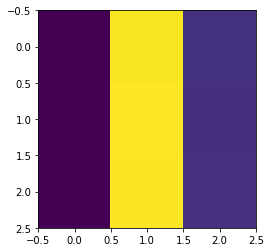

In [13]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total trainable parameters:', total_params)

# print('confusion_matrix= \n', confusion_matrix, '\n')
plt.imshow(confusion_matrix)
plt.show()

# part Jim

In [ ]:
# tensorboard: http://localhost:6006/
# browse to this url and see plots

# part D

In [18]:
# CNN
epochs = 20

model = CNN_NN().to(device)

loss_func = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters())

writer = SummaryWriter()
best_acc = 0
for epoch in range(epochs):
  print(f"Epoch: {epoch+1}")
  train_loss, train_acc, _, _, _ = train_loop(train_dataloader, model, loss_func, optimizer)
  test_loss, test_acc, precision, recall, confusion_matrix = test_loop(test_dataloader, model, loss_func)

  writer.add_scalars('CNN_loss', {'test_loss':test_loss, 'train_loss':train_loss}, epoch)
  writer.add_scalars('CNN_acc', {'test_accurracy':test_acc, 'train_accurracy':train_acc}, epoch)


  if test_acc > best_acc:
    best_acc = test_acc
    torch.save(model, 'best_CNN_model.pt')

writer.close()


Epoch: 1
train error:
 Accuracy: 87.9%, precision: 87.9%, recall: 87.9%, Average loss: 0.777148
test error:
 Accuracy: 88.7%, precision: 88.8%, recall: 88.7%, Average loss: 0.772862 

Epoch: 2
train error:
 Accuracy: 88.3%, precision: 88.3%, recall: 88.3%, Average loss: 0.773752
test error:
 Accuracy: 88.6%, precision: 88.7%, recall: 88.6%, Average loss: 0.772971 

Epoch: 3
train error:
 Accuracy: 89.0%, precision: 89.0%, recall: 89.0%, Average loss: 0.769895
test error:
 Accuracy: 88.7%, precision: 88.7%, recall: 88.7%, Average loss: 0.771111 

Epoch: 4
train error:
 Accuracy: 89.1%, precision: 89.1%, recall: 89.1%, Average loss: 0.768981
test error:
 Accuracy: 88.6%, precision: 88.6%, recall: 88.6%, Average loss: 0.772237 

Epoch: 5
train error:
 Accuracy: 89.3%, precision: 89.3%, recall: 89.3%, Average loss: 0.766731
test error:
 Accuracy: 88.8%, precision: 88.9%, recall: 88.8%, Average loss: 0.769114 

Epoch: 6
train error:
 Accuracy: 89.3%, precision: 89.3%, recall: 89.3%, Average

total trainable parameters: 21315


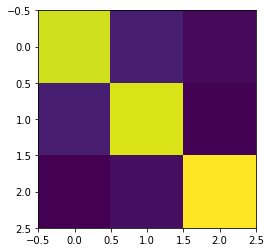

In [19]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total trainable parameters:', total_params)

# print('confusion_matrix= \n', confusion_matrix, '\n')
plt.imshow(confusion_matrix)
plt.show()

In [ ]:
# tensorboard: http://localhost:6006/
# browse to this url and see plots

# part H

training for 5 epoch:

MLP: Accuracy: 33.5%, precision: 36.1%, recall: 33.5%, Average loss: 1.213902 
CNN: Accuracy: 87.1%, precision: 87.7%, recall: 87.1%, Average loss: 0.786522

CNN best model: (epochs=20)
CNN: Accuracy: 90.4%, precision: 90.5%, recall: 90.4%, Average loss: 0.759891 

# part V

pip install dropblock
https://github.com/miguelvr/dropblock

Although dropout is widely used as a regularization technique for fully connected layers, it is often less effective for convolutional layers. This lack of success of dropout for convolutional layers is perhaps due to the fact that activation units in convolutional layers are spatially correlated so information can still flow through convolutional networks despite dropout. Thus a structured form of dropout is needed to regularize convolutional networks. DropBlock, a form of structured dropout, drops out units in a contiguous region of a feature map together. 

In [20]:

from dropblock import DropBlock2D

class CNN_DropBlock(nn.Module):
  def __init__(self):
    super(CNN_DropBlock, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3), #136*102*3
        DropBlock2D(block_size=3, drop_prob=0.3),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3), #68*50*16
        DropBlock2D(block_size=3, drop_prob=0.3),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3), #33*24*32
        DropBlock2D(block_size=3, drop_prob=0.3),
        nn.AvgPool2d(kernel_size=(22,30)),
        nn.Flatten(),
        nn.Softmax()
    )


  def forward(self,x):
    out = self.net(x)

    return out


epochs = 20

model = CNN_DropBlock().to(device)

loss_func = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters())

writer = SummaryWriter()
best_acc = 0
for epoch in range(epochs):
  print(f"Epoch: {epoch+1}")
  train_loss, train_acc, _, _, _ = train_loop(train_dataloader, model, loss_func, optimizer)
  test_loss, test_acc, precision, recall, confusion_matrix = test_loop(test_dataloader, model, loss_func)

  writer.add_scalars('CNN_CNN_DropBlock_loss', {'test_loss':test_loss, 'train_loss':train_loss}, epoch)
  writer.add_scalars('CNN_CNN_DropBlock_acc', {'test_accurracy':test_acc, 'train_accurracy':train_acc}, epoch)


  if test_acc > best_acc:
    best_acc = test_acc
    torch.save(model, 'best_CNN_CNN_DropBlock_model.pt')

writer.close()


Epoch: 1
train error:
 Accuracy: 78.6%, precision: 78.5%, recall: 78.6%, Average loss: 0.854606
test error:
 Accuracy: 82.2%, precision: 82.3%, recall: 82.2%, Average loss: 0.823334 

Epoch: 2
train error:
 Accuracy: 81.4%, precision: 81.4%, recall: 81.4%, Average loss: 0.827617
test error:
 Accuracy: 82.0%, precision: 82.6%, recall: 81.9%, Average loss: 0.820711 

Epoch: 3
train error:
 Accuracy: 82.6%, precision: 82.5%, recall: 82.6%, Average loss: 0.818533
test error:
 Accuracy: 84.1%, precision: 84.3%, recall: 84.1%, Average loss: 0.805663 

Epoch: 4
train error:
 Accuracy: 83.7%, precision: 83.6%, recall: 83.7%, Average loss: 0.810316
test error:
 Accuracy: 84.6%, precision: 84.6%, recall: 84.6%, Average loss: 0.805985 

Epoch: 5
train error:
 Accuracy: 83.9%, precision: 83.8%, recall: 83.9%, Average loss: 0.808433
test error:
 Accuracy: 83.4%, precision: 84.1%, recall: 83.3%, Average loss: 0.808775 

Epoch: 6
train error:
 Accuracy: 84.5%, precision: 84.5%, recall: 84.5%, Average

total trainable parameters: 21315


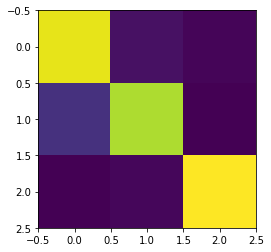

In [21]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total trainable parameters:', total_params)

plt.imshow(confusion_matrix)
plt.show()

# part Z: factorization

مزایا: کاهش تعداد وزن های یادگیری، سرعت بیشتر در آموزش شبکه، رگولاریزاسیون و تعمیم پذیری بهتر

In [22]:
# https://discuss.pytorch.org/t/how-to-modify-a-conv2d-to-depthwise-separable-convolution/15843/6
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out
    
    
class CNN_factorized_NN(nn.Module):
  def __init__(self):
    super(CNN_factorized_NN, self).__init__()
    self.net = nn.Sequential(
        depthwise_separable_conv(3,32,3),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        depthwise_separable_conv(32,64,3),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        depthwise_separable_conv(64,3,3),
        nn.AvgPool2d(kernel_size=(22,30)),
        nn.Flatten(),
        nn.Softmax()
    )


  def forward(self,x):
    out = self.net(x)

    return out


# CNN
epochs = 20

model = CNN_factorized_NN().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total trainable parameters:', total_params)

loss_func = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters())

writer = SummaryWriter()
best_acc = 0
for epoch in range(epochs):
  print(f"Epoch: {epoch+1}")
  train_loss, train_acc, _, _, _ = train_loop(train_dataloader, model, loss_func, optimizer)
  test_loss, test_acc, precision, recall, confusion_matrix = test_loop(test_dataloader, model, loss_func)

  writer.add_scalars('CNN_factorized_loss', {'test_loss':test_loss, 'train_loss':train_loss}, epoch)
  writer.add_scalars('CNN_factorized_acc', {'test_accurracy':test_acc, 'train_accurracy':train_acc}, epoch)


  if test_acc > best_acc:
    best_acc = test_acc
    torch.save(model, 'best_CNN_factorized_model.pt')

writer.close()


total trainable parameters: 3617
Epoch: 1
train error:
 Accuracy: 73.2%, precision: 72.7%, recall: 73.2%, Average loss: 0.898611
test error:
 Accuracy: 79.6%, precision: 79.4%, recall: 79.5%, Average loss: 0.848266 

Epoch: 2
train error:
 Accuracy: 79.9%, precision: 79.8%, recall: 79.9%, Average loss: 0.839095
test error:
 Accuracy: 82.3%, precision: 82.5%, recall: 82.3%, Average loss: 0.828409 

Epoch: 3
train error:
 Accuracy: 82.1%, precision: 82.1%, recall: 82.1%, Average loss: 0.824453
test error:
 Accuracy: 83.3%, precision: 83.3%, recall: 83.3%, Average loss: 0.814548 

Epoch: 4
train error:
 Accuracy: 83.5%, precision: 83.6%, recall: 83.5%, Average loss: 0.812560
test error:
 Accuracy: 84.2%, precision: 84.7%, recall: 84.2%, Average loss: 0.807516 

Epoch: 5
train error:
 Accuracy: 84.3%, precision: 84.3%, recall: 84.3%, Average loss: 0.805244
test error:
 Accuracy: 85.7%, precision: 85.8%, recall: 85.7%, Average loss: 0.797167 

Epoch: 6
train error:
 Accuracy: 84.8%, precisi

total trainable parameters: 3617


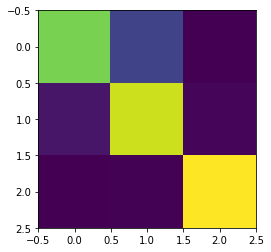

In [23]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total trainable parameters:', total_params)

plt.imshow(confusion_matrix)
plt.show()

# results

MLP: Accuracy: 33.5%, precision: 36.1%, recall: 33.5%, Average loss: 1.213902, #parameters: 4166903
CNN: Accuracy: 90.4%, precision: 90.5%, recall: 90.4%, Average loss: 0.759891, #parameters: 21315
CNN_DropBlock: Accuracy: 89.0%, precision: 89.1%, recall: 89.0%, Average loss: 0.770839, #parameters: 21315
CNN_factorized: Accuracy: 87.9%, precision: 88.2%, recall: 87.9%, Average loss: 0.781098, #parameters: 3617